# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### logistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 로지스틱회귀후에 .coef_ 항목에서 기준(criteria, 계수)보다 높은 영향력을 미치는 feature column 선택
def select_features(df, coef, criteria):
    sel_num = np.where(np.abs(coef) > criteria )[1]
    sel_col = df.columns[sel_num]
    return sel_col

In [3]:
def get_scores(data, target):
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

    ss = StandardScaler()
    ss.fit(train_input)
    train_scaled = ss.transform(train_input)
    test_scaled = ss.transform(test_input)

    lr = LogisticRegression(C=20, max_iter=4000) # max_iter default 100, 
#     lr = LogisticRegression(C=1, solver='newton_cg', max_iter=1000) # max_iter default 100, 
    lr.fit(train_scaled, train_target)

    train_score = lr.score(train_scaled, train_target)
    test_score = lr.score(test_scaled, test_target)
#     print(f'train score: {train_score:.4f} \n test score; {test_score:.4f}')
    return train_score, test_score, lr.coef_, lr.intercept_

In [4]:
def find_best_result(data, target):
# min을 하나씩 제거하면서 최고의 결과를 가져오는 feature갯수(항목) 선택

    train_score_list= []
    test_score_list = []
#     data_columns = []
#     data_coef = []
    test_s = 0
    train_score, test_score, coef, intercept = get_scores(data, target)
    for _ in range(len(data.columns)-1):
        criteria = np.abs(coef).min()
        sel_col = select_features(data, coef, criteria)
        data = df[sel_col]
        train_score, test_score, coef, intercept = get_scores(data, target)

        if test_score > test_s:
            test_s = test_score
            data_columns = sel_col
            data_coef = coef

        train_score_list.append(train_score)
        test_score_list.append(test_score)
    
    return train_score_list, test_score_list, data_columns, data_coef

In [5]:
import pickle
def list_to_pickle(filename, listname):
    open_file = open(filename, "wb")
    pickle.dump(listname, open_file)
    open_file.close()

def list_from_pickle(filename):
    open_file = open(filename, "rb")
    loaded_list = pickle.load(open_file)
    open_file.close()
    return loaded_list

In [6]:
# 분석용 데이터 입력
stock_name = 'sec'
directory_for_ml = '../data/data_for_ml/'
fname = f'df_{stock_name}_sel.pkl'
f_name = directory_for_ml + fname
df = pd.read_pickle(f_name)
plt_title = fname[3:7]

In [7]:
data = df.iloc[:, :-5]

# target = df.iloc[:, -5]
# col_num = int(len(data.columns)/4)
# data = data.iloc[:, :col_num]
# target = target.apply(lambda x : 0 if ((x == 1) | (x ==2)) else 1 ) # 최고가 시간이 오후인 경우
# # target = target.apply(lambda x : 0 if ((x == 1) | (x ==2)) else (1 if x == 3 else  2 ))
# plt_title2 = '4classes'

# target = df.iloc[:, -1]
# plt_title2 = 'r_open_high_1'

# target = df.iloc[:, -2]
# plt_title2 = 'close_cr_1'

# target = df.iloc[:, -3]
# plt_title2 = 'r_open_high_5'

target = df.iloc[:, -4]
plt_title2 = 'close_cr_5'

In [8]:
train_score_list, test_score_list, data_columns, data_coef = find_best_result(data, target)

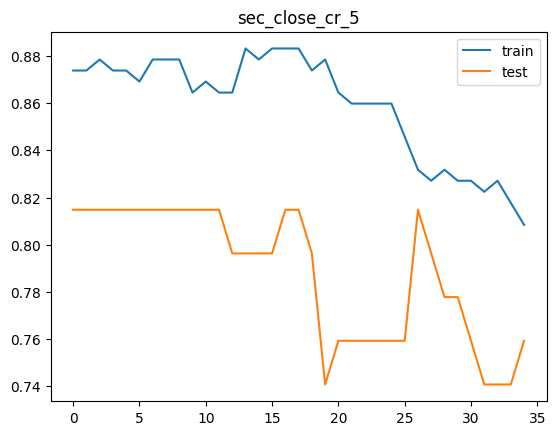

In [9]:
plt.plot(train_score_list, label = 'train')
plt.plot(test_score_list, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

In [10]:
print(data_columns, data_coef)
print("train_max: {:.4f}, test_max: {:.4f}".format(max(train_score_list), max(test_score_list)))

Index(['retail', 'foreigner', 'institution', 'financial', 'invtrust',
       'pension', 'privequity', 'bank', 'insurance', 'corporateetc',
       'foreigneretc', 'open', 'high', 'low', 'close', 'vol', 'dji_cr',
       'dji_f_cr', 'ixic_cr', 'ixic_f_cr', 'spx_cr', 'spx_f_cr',
       'bond_kor_10_cr', 'bond_kor_2_cr', 'dxy_cr', 'bond_usa_10_cr',
       'bond_usa_2_cr', 'bond_usa_3m_cr', 'kosdaq_cr', 'kospi_cr', 'krw_cr',
       'sox_cr', 'vix_cr', 'wti_cr', 'weekday'],
      dtype='object') [[-0.39649309  0.07066923 -1.25095891 -0.44484109 -0.12012857  0.47353441
  -0.43863584 -1.0015876  -0.18440636  0.23266379  0.29770973 -0.98793082
  -0.07606895  0.85478281 -0.19112226 -0.1402485  -0.42878139 -1.63194317
  -1.30971428  1.01162013  0.30928571  1.72434021  0.13973126 -0.36347755
   0.0997334  -0.01879626 -0.36756576  0.34279053 -0.84521466  3.82513942
  -0.33232589  0.65554623  0.29733295 -0.02226748  0.27539535]]
train_max: 0.8832, test_max: 0.8148


In [78]:
dfc = pd.DataFrame(data_coef.T, index=data_columns, columns=['value'])
dfc

,value
retail,-0.396493
foreigner,0.070669
institution,-1.250959
financial,-0.444841
invtrust,-0.120129
pension,0.473534
privequity,-0.438636
bank,-1.001588
insurance,-0.184406
corporateetc,0.232664


(array([20.,  5.,  5.,  2.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01879626, 0.39943057, 0.78006489, 1.16069921, 1.54133352,
        1.92196784, 2.30260216, 2.68323647, 3.06387079, 3.4445051 ,
        3.82513942]),
 <BarContainer object of 10 artists>)

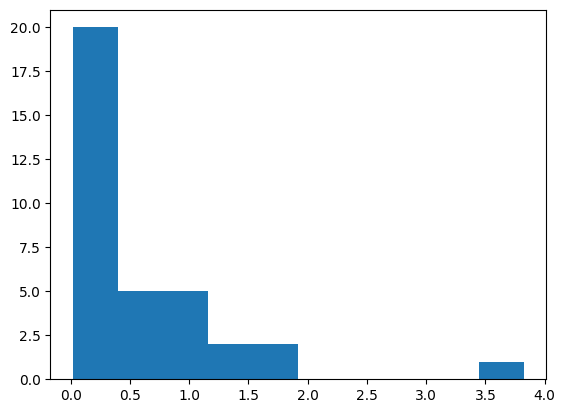

In [85]:
plt.hist(abs(dfc['value']))

In [137]:
dfc_new = dfc[abs(dfc['value']) > abs(dfc['value']).mean()]
dfc_new.index
data_columns = ['institution', 'dji_f_cr', 'ixic_cr', 
                'ixic_f_cr', 'spx_f_cr', 'kosdaq_cr', 'kospi_cr', 'sox_cr']
data_columns = ['ixic_cr', 'ixic_f_cr', 'spx_f_cr', 'kospi_cr'] # from small dataset

In [138]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [139]:
data_new = data[data_columns]
# target = df.iloc[:, -2]  # logistic regression에서 생성된 target을 그대로 사용

In [140]:
train_input, test_input, train_target, test_target = train_test_split(data_new, target, random_state=42, test_size=0.2, stratify=target)

In [141]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [142]:
value = []
for iter in range(5, 50, 1):
    sc = SGDClassifier(loss='log', max_iter=iter, random_state=42)
#     sc = SGDClassifier(max_iter=iter, random_state=42)
    scores = cross_validate(sc,
                            X=train_scaled, y=train_target,
                            n_jobs=-1)
#     print(scores['test_score'].mean())
    value.append(scores['test_score'].mean())

In [143]:
print("max", max(value))

max 0.7802879291251383


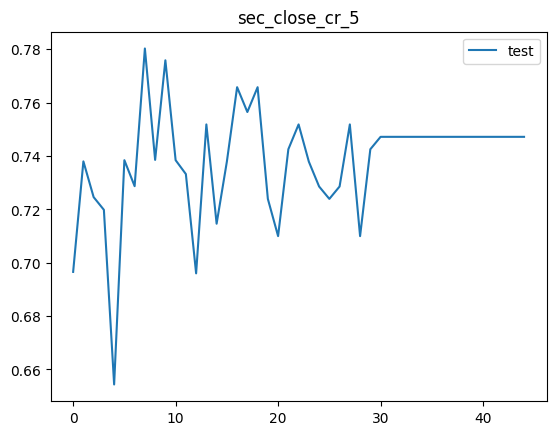

In [144]:
plt.plot(value, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

### 인공신경망

In [145]:
def model_fn(inp_num, a_layer=None):
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(inp_num,)))
#     model.add(Dropout(0.3))
    model.add(Dense(12, activation='sigmoid'))
    model.add(Dense(4, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dropout(0.1))
    if a_layer:
        model.add(a_layer)
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [146]:
d_rate = 1e-7 # default value
adam_custom = tf.keras.optimizers.Adam(
    learning_rate=0.0002, # default  0.001 , best fit 0.0001 for skhinix
    beta_1=0.9, beta_2=0.999, epsilon=d_rate, amsgrad=False,  # default
    weight_decay=None, clipnorm=None, clipvalue=None, global_clipnorm=None, use_ema=False, ema_momentum=0.99,
    ema_overwrite_frequency=None, jit_compile=True, name='Adam' )

In [147]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
try :
    model = None
    print("delete del")
except:
    pass
model = model_fn(len(data_new.columns))
# model.compile(optimizer='adam', loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer=adam_custom, loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

delete del
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 12)                60        
                                                                 
 dense_69 (Dense)            (None, 12)                156       
                                                                 
 dense_70 (Dense)            (None, 4)                 52        
                                                                 
 dropout_21 (Dropout)        (None, 4)                 0         
                                                                 
 dense_71 (Dense)            (None, 4)                 20        
                                                                 
 dropout_22 (Dropout)        (None, 4)                 0         
                                                                 
 dense_72 (Dense)            (None, 2)    

In [148]:
# checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
today = datetime.date.today().isoformat()
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath='best_model/best_model_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5', \
     save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', \
#                                                 monitor='val_accuracy', mode='max', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', save_best_only=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_accuracy', mode='max', restore_best_weights=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=150, monitor='val_loss', mode='min', restore_best_weights=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

In [149]:
history = model.fit(train_scaled, train_target, epochs=10000, verbose=0, batch_size=32,
                    callbacks=[checkpoint_cb, earlystopping_cb],
                    validation_data=(test_scaled, test_target))

# loss 가 최저로 내려가지 않거나 큰 상태에서 머무르면 adam (optimizer)의 learning rate를 줄이면서 loss가 작아지는지 시도해 볼 것
# batch size 도 조절
# layer를 추가하면서 진행도 많이 도움됨.(mobis 경우에 적용)

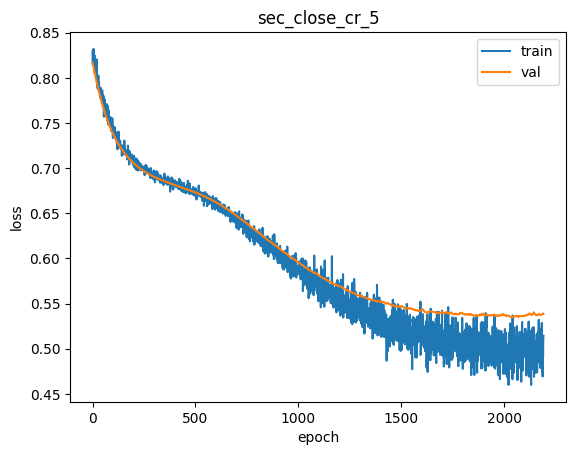

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title(plt_title+plt_title2)
plt.show()

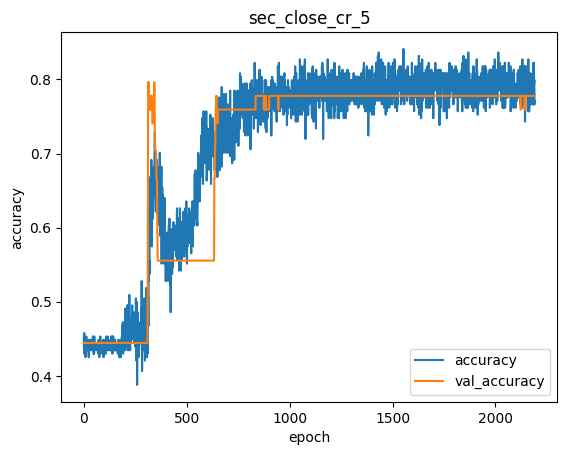

In [151]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title(plt_title+plt_title2)
plt.show()

In [152]:
# save feature columns
directory = f'best_model_{stock_name}/'
list_to_pickle(directory+f'data_columns_{stock_name}.pkl', data_columns)

In [153]:
earlystopping_cb.stopped_epoch

2191

In [154]:
model.evaluate(test_scaled, test_target)

2/2 [==============================] - 0s 2ms/step - loss: 0.5350 - accuracy: 0.7778


[0.534993588924408, 0.7777777910232544]

In [155]:
model_val = load_model('best_model/best_model_1736-0.26-0.88.h5')
model_val.evaluate(test_scaled, test_target)

OSError: No file or directory found at best_model/best_model_1736-0.26-0.88.h5

In [156]:
y_predict = model.predict(np.array(test_scaled))

2/2 [==============================] - 0s 2ms/step


In [157]:
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]

In [158]:
compare = [ [x, y] for x, y in zip(test_target, y_predict)]
# compare = [ [x, y] for x, y in zip(test_target, y_predict_list)]
compare # 실제값. 예측값

[[0, array([0.22430548], dtype=float32)],
 [1, array([0.75455034], dtype=float32)],
 [0, array([0.2243033], dtype=float32)],
 [0, array([0.22430746], dtype=float32)],
 [0, array([0.22430328], dtype=float32)],
 [0, array([0.7531651], dtype=float32)],
 [0, array([0.22430354], dtype=float32)],
 [0, array([0.22430393], dtype=float32)],
 [0, array([0.22430342], dtype=float32)],
 [0, array([0.22430328], dtype=float32)],
 [0, array([0.22430332], dtype=float32)],
 [1, array([0.752561], dtype=float32)],
 [0, array([0.22430398], dtype=float32)],
 [0, array([0.75454104], dtype=float32)],
 [1, array([0.75454694], dtype=float32)],
 [1, array([0.7541044], dtype=float32)],
 [0, array([0.2243033], dtype=float32)],
 [0, array([0.22430328], dtype=float32)],
 [1, array([0.2243075], dtype=float32)],
 [0, array([0.22431162], dtype=float32)],
 [0, array([0.22573228], dtype=float32)],
 [0, array([0.22518633], dtype=float32)],
 [1, array([0.7542432], dtype=float32)],
 [1, array([0.224338], dtype=float32)],
 [

In [159]:
from sklearn.metrics import precision_score, recall_score
# 정밀도 : 양성으로 예측된 것(TP+FP) 중 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
precision_score(test_target, y_predict_list)  # 정밀도, 입력값의 순서 중요힘. (실제값, 예측값)

0.8

In [160]:
# 재현율 : 전체 양성 샘플(TP+FN) 중에서 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
recall_score(test_target, y_predict_list)  # 재현율, 입력값의 순서 중요힘. (실제값, 예측값)

0.6666666666666666

In [161]:
from sklearn.metrics import f1_score

f1_score(test_target, y_predict_list)

0.7272727272727272

In [162]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_target, y_predict_list)

array([[26,  4],
       [ 8, 16]], dtype=int64)

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_target, y_predict_list)

0.9099264705882353

1. 정밀도, f1-score, 
2. confusion matrix ((1,1), (2,2), 두개가 큰 비중이면 good, (1,2)은 틀린것을 맞다라고 구분, (2,1)은 맞는 것을 틀린 것이다 라고 결정하는 항목) 따라서
    (2,2) -> (1,2) -> (1,1)로 확인하고. <br>
    (1,2)가 크면 모델 제외 (정밀도(precision = TP / (TP + FP) )가 높아야 함. 낮으면 손해를 보게 됨.), <br>
    재현율(Recall = TP / (TP + FN) ) 은 손해를 끼치지는 않음.
    
<img src="https://raw.githubusercontent.com/fasthill/My-gist/main/data/picture/confusion_matrix.png" width="800"/> <br>

In [ ]:
# val[1] = 'sec'
directory = f'best_model_sec/'
list_to_pickle(directory+'data_columns.pkl', data_columns)

In [ ]:
for innum in range(30):
    aa = np.array([test_scaled[innum]])
    y_predict = model.predict(aa)
#     print("predict: {},  target_value: {}".format(y_predict, test_target[innum]))

In [ ]:
### ROC 확인해 봐야 함. 정확도, 정밀도 등

In [ ]:
'''
model.save('my_model.h5')
model_new = load_model('my_model.h5')
model_new.evaluate(test_scaled, test_target)
'''

수수료: 주식거래수수료 0.015%. 유관기관수수료 0.0036%, 증권거래세 0.08, 농어촌 특별세 0.15%
수수료 : (0.015+0.0036 ) * 2 (사고팔때), 증권거래세 : 0.08 + 0.15 (팔때)
전체 지출 금액율: 0.2672%